In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import pickle
import random
import math
random.seed = 421


plt.style.use(["science", "no-latex"])
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def load_res(save_loc):
    with open("results/{}".format(save_loc), "rb") as f:
        res = pickle.load(f)

    return res


def avg_across_dicts(dicts):
    """

    Args:
        dicts: list of dictionaries with same keys and lists as elements

    Returns:
        single dict with the keys and average of lists

    """
    avg_dict = dict()
    keys = dicts[0].keys()
    for k in keys:
        values = []
        for d in dicts:
            values.append(d[k])
        avg_dict[k] = np.mean(values, axis=0)

    return avg_dict


def str_contains(word_list, string):
    for word in word_list:
        if word not in string:
            return False

    return True

In [3]:
dtype = "cifar_5" # mnist_5 / fmnist_5 / cifar_5 / mnist_10 / fmnist_10 / cifar_10

indicators, t1_indicators = None, None

if dtype == "fmnist_5":
    indicators = ["mnist.FashionMNIST", "classes.5", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.5", "-t1"]
elif dtype == "fmnist_10":
    indicators = ["mnist.FashionMNIST", "classes.10", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.10", "-t1"]
elif dtype == "mnist_5":
    indicators = ["mnist.MNIST", "classes.5", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.5", "-t1"]
elif dtype == "mnist_10":
    indicators = ["mnist.MNIST", "classes.10", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.10", "-t1"]
elif dtype == "cifar_5":
    indicators = ["cifar.CIFAR10", "classes.5", "-avg"]
    t1_indicators = ["cifar.CIFAR10", "classes.5", "-t1"]
elif dtype == "cifar_10":
    indicators = ["cifar.CIFAR10", "classes.10", "-avg"]
    t1_indicators = ["cifar.CIFAR10", "classes.10", "-t1"]
elif dtype == "NovelNet":
    indicators = ["NovelNet", "-avg"]
    t1_indicators = ["NovelNet", "-t1"]


files = os.listdir("results")
list_res_dicts = []
list_t1_dicts = []
for _alg_type in ['naive', 'ewc', 'lwf']:
    result_dicts = [
        load_res(f)
        for f in files
        if f[-3:] == "pkl" and str_contains(indicators + [_alg_type], f) and not
        str_contains(['epochs.3'], f)
    ]
    t1_dicts = [
        load_res(f)
        for f in files
        if f[-3:] == "pkl" and str_contains(t1_indicators + [_alg_type], f) and not
        str_contains(['epochs.3'], f)
    ]

    result_dicts, t1_dicts = [avg_across_dicts(result_dicts)], [
        avg_across_dicts(t1_dicts)]
    
    list_res_dicts.append(result_dicts), list_t1_dicts.append(t1_dicts)

# change the load_res argument in accordance with dtype:
# mnist_5 -> 'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.pkl'
# mnist_10 -> 'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST.pkl'
# fmnist_5 -> 'cd_score.naive-curriculum_torchvision.datasets.mnist.FashionMNIST_classes.5.pkl'
# fmnist_10 -> 'cd_score.naive-curriculum_torchvision.datasets.mnist.FashionMNIST.pkl'
# cifar_5 -> 'cd_score.naive-curriculum_torchvision.datasets.cifar.CIFAR10_classes.5.pkl'
# cifar_10 -> 'cd_score.naive-curriculum_torchvision.datasets.cifar.CIFAR10.pkl'
algo_dict = load_res(
    'cd_score.naive-curriculum_torchvision.datasets.cifar.CIFAR10_classes.5.pkl')
algo_dict = dict(
    sorted(algo_dict.items(), key=lambda item: item[1], reverse=True))

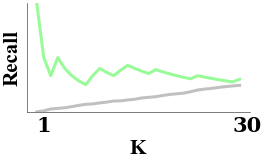

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def recall_at_k(list1, list2, k):
    relevant_items = set(list2[:k])
    retrieved_items = flatten(list1[:k])
    intersection = set(retrieved_items) & relevant_items
    recall = len(intersection) / len(relevant_items)
    return recall

def recall_at_k_rand(list1, list2, k):
    relevant_items = set(list2[:k])
    retrieved_items = list1[:k]
    intersection = set(retrieved_items) & relevant_items
    recall = len(intersection) / len(relevant_items)
    return recall


def calculate_iou_at_k(list1, list2, k):
    # Select the top k elements from each list
    top_k_list1 = list1[:k]
    top_k_list2 = list2[:k]

    # Calculate the intersection and union
    intersection = len(set(top_k_list1) & set(top_k_list2))
    union = len(set(top_k_list1 + top_k_list2))

    # Calculate the IoU
    iou = intersection / union

    return iou


def plot_list_of_lists(data, legends):
    plt.figure(figsize=(4, 2))
    for idx, sublist in enumerate(data):
        if idx == 0:
            plt.plot(sublist, linewidth=3, color='palegreen')
        else:
            plt.plot(sublist, linewidth=3, color='silver')
        

    mpl.rcParams['axes.linewidth'] = 2
    mpl.rcParams['axes.spines.left'] = True
    plt.xlabel('K', fontdict={'weight': 'bold', 'size': 21, 'fontname': 'Times New Roman'})
    plt.ylim(0,1)
    plt.ylabel('Recall', fontdict={'weight': 'bold', 'size': 21, 'fontname': 'Times New Roman'})
    plt.yticks([], weight='bold', size=21)
    plt.xticks([1, 30], weight='bold', size=21)
    # plt.legend(legends, loc="upper right",)
    plt.tick_params(axis="x", which="both", bottom=False, top=False)
    plt.tick_params(axis="y", which="both", left=False, right=False)
    plt.savefig('rebuttal.fig.{}.{}.png'.format(dtype, 'comb'), dpi=200)
    plt.show()
    plt.close()


def convert_tuple(tuple_data):
    return '[' + ', '.join(str(x) for x in tuple_data) + ']'


top_k = 31
f_dicts = []
for result_dicts, t1_dicts in zip(list_res_dicts, list_t1_dicts):
    for _avg, _t1 in zip(result_dicts, t1_dicts):
        f_var = {
            k: (2 * v[-1]) / ((v_t1[0] - v_t1[-1]) * v[-1] + 1)
            for v, v_t1, k in zip(_avg.values(), _t1.values(), _avg.keys())
        }
        f_var = dict(sorted(f_var.items(), key=lambda item: item[1], reverse=True))
        f_dicts.append(f_var)
f_lists = [list(f_dict.keys()) for f_dict in f_dicts]
f_lists = [[[x, y, z] for x, y, z in zip(f_lists[0], f_lists[1], f_lists[2])]]
f_lists_rand = [[x[0] for x in f_lists[0]]]

algo_dict = dict(
    sorted(algo_dict.items(), key=lambda item: item[1], reverse=True))
algo_list = list(algo_dict.keys())
algo_list = [convert_tuple(x) for x in algo_list]

recall_all, iou_all = [], []
for f_list in f_lists:
    recall, iou = [], []
    for _k in range(1, top_k):
        recall.append(recall_at_k(f_list, algo_list, _k))
        # iou.append(calculate_iou_at_k(algo_list, f_list, _k))
    recall_all.append(recall)
    # iou_all.append(iou)

recall_random, iou_random = [], []
num_random = 100
for f_list in f_lists_rand:
    for _ in range(num_random):
        rand_list = random.sample(f_list, len(f_list))
        recall, iou = [], []
        for _k in range(1, top_k):
            recall.append(recall_at_k_rand(rand_list, algo_list, _k))
            # iou.append(calculate_iou_at_k(algo_list, rand_list, _k))
        recall_random.append(recall)
recall_random = np.mean(recall_random, axis=0)
# iou_random = np.mean(iou_random, axis=0)
recall_all.append(recall_random)
# iou_all.append(recall_random)

plot_list_of_lists(recall_all, legends=[
                   'Recall@K', 'random'])

In [5]:
# for the bar plots, use the same dtype as above to produce corresponding plots

dtype = "mnist_5"

indicators, t1_indicators = None, None

if dtype == "fmnist_5":
    indicators = ["mnist.FashionMNIST", "classes.5", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.5", "-t1"]
elif dtype == "fmnist_10":
    indicators = ["mnist.FashionMNIST", "classes.10", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.10", "-t1"]
elif dtype == "mnist_5":
    indicators = ["mnist.MNIST", "classes.5", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.5", "-t1"]
elif dtype == "mnist_10":
    indicators = ["mnist.MNIST", "classes.10", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.10", "-t1"]
elif dtype == "cifar_5":
    indicators = ["cifar.CIFAR10", "classes.5", "-avg"]
    t1_indicators = ["cifar.CIFAR10", "classes.5", "-t1"]
elif dtype == "cifar_10":
    indicators = ["cifar.CIFAR10", "classes.10", "-avg"]
    t1_indicators = ["cifar.CIFAR10", "classes.10", "-t1"]
elif dtype == "NovelNet":
    indicators = ["NovelNet", "-avg"]
    t1_indicators = ["NovelNet", "-t1"]

In [6]:
# the load_res argument for all elements in the algo_dicts list should be corresponding to the dtype
# follow the pattern, as specified above

files = os.listdir("results")
list_res_dicts = []
list_t1_dicts = []
for _alg_type in ['naive', 'ewc', 'lwf']:
    result_dicts = [
        load_res(f)
        for f in files
        if f[-3:] == "pkl" and str_contains(indicators + [_alg_type], f) and not
        str_contains(['epochs.3'], f)
    ]
    t1_dicts = [
        load_res(f)
        for f in files
        if f[-3:] == "pkl" and str_contains(t1_indicators + [_alg_type], f) and not
        str_contains(['epochs.3'], f)
    ]

    result_dicts, t1_dicts = [avg_across_dicts(result_dicts)], [
        avg_across_dicts(t1_dicts)]
    
    list_res_dicts.append(result_dicts), list_t1_dicts.append(t1_dicts)
algo_dicts = [
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.cosine.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.euclidean.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.otdd.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.11.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.6.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.ResNet18_ImageNet100.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.ResNet34_ImageNet100.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.SqueezeNet_MNIST.pkl'),
    load_res(
    'cd_score.naive-curriculum_torchvision.datasets.mnist.MNIST_classes.5.ResNet18_random.pkl')
]

[[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.1, 0.09090909090909091, 0.08333333333333333, 0.07692307692307693, 0.07142857142857142, 0.13333333333333333, 0.125, 0.11764705882352941, 0.16666666666666666, 0.21052631578947367, 0.2, 0.19047619047619047, 0.22727272727272727, 0.21739130434782608, 0.20833333333333334, 0.24, 0.2692307692307692, 0.2962962962962963, 0.32142857142857145, 0.3448275862068966, 0.36666666666666664], [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.1, 0.09090909090909091, 0.08333333333333333, 0.07692307692307693, 0.07142857142857142, 0.06666666666666667, 0.0625, 0.058823529411764705, 0.1111111111111111, 0.21052631578947367, 0.25, 0.23809523809523808, 0.2727272727272727, 0.30434782608695654, 0.3333333333333333, 0.32, 0.3076923076923077, 0.2962962962962963, 0.32142857142857145, 0.3448275862068966, 0.36666666666666664], [0.0, 0.0, 0.0, 0.0, 

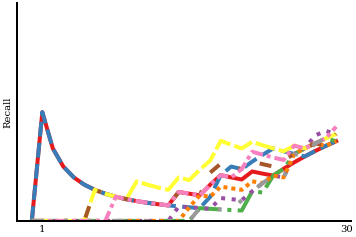

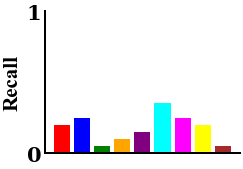

In [7]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def recall_at_k(list1, list2, k):
    relevant_items = set(list2[:k])
    retrieved_items = flatten(list1[:k])
    intersection = set(retrieved_items) & relevant_items
    recall = len(intersection) / k
    return recall

def recall_at_k_rand(list1, list2, k):
    relevant_items = set(list2[:k])
    retrieved_items = list1[:k]
    intersection = set(retrieved_items) & relevant_items
    recall = len(intersection) / k
    return recall


def calculate_iou_at_k(list1, list2, k):
    # Select the top k elements from each list
    top_k_list1 = list1[:k]
    top_k_list2 = list2[:k]

    # Calculate the intersection and union
    intersection = len(set(top_k_list1) & set(top_k_list2))
    union = len(set(top_k_list1 + top_k_list2))

    # Calculate the IoU
    iou = intersection / union

    return iou


def plot_bar(data, idx, legends):
    data = data[idx]
    colors = ["red", "blue", "green", "orange", "purple", "cyan", "magenta", "yellow", "brown"]


    mpl.rcParams['axes.linewidth'] = 2
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.bottom'] = True
    fig, ax = plt.subplots()
    plt.bar(np.arange(len(data)), data, color=colors)

    # plt.xlabel('cd ablations', fontdict={'weight': 'bold', 'size': 21, 'fontname': 'TImes New Roman'})
    plt.ylim(0,1)
    plt.ylabel('Recall', fontdict={'weight': 'bold', 'size': 21, 'fontname': 'TImes New Roman'})
    plt.yticks([0, 1], weight='bold', size=21)
    plt.xticks([], weight='bold', size=21)
    plt.tick_params(axis="x", which="both", bottom=False, top=False)
    plt.tick_params(axis="y", which="both", left=False, right=False)
    plt.savefig('rebuttal.fig__bars__{}.{}.{}.{}.png'.format(idx, dtype, 'comb', 'ablation'), dpi=200)
    # ax.legend(legends)

    plt.show()


def plot_list_of_lists(data, legends):
    colors = plt.cm.Set1(np.linspace(0, 1, len(data)))
    linestyles = linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (5, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5))]
    plt.figure(figsize=(6, 4))
    for sublist, color, style in zip(data, colors, linestyles):
        plt.plot(sublist, linewidth=4, color=color, linestyle=style)

    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.bottom'] = True
    # plt.xlabel('K')
    plt.ylim(0,1)
    plt.ylabel('Recall')
    plt.yticks([])
    plt.xticks([1, 30])
    # plt.legend(legends, loc="upper left", ncol=len(data), fontsize='large')
    plt.tick_params(axis="x", which="both", bottom=False, top=False)
    plt.tick_params(axis="y", which="both", left=False, right=False)
    plt.savefig('rebuttal.fig.{}.{}.{}.png'.format(dtype, 'comb', 'ablation'), dpi=200)
    plt.show()
    plt.close()


def convert_tuple(tuple_data):
    return '[' + ', '.join(str(x) for x in tuple_data) + ']'


top_k = 31
f_dicts = []
for result_dicts, t1_dicts in zip(list_res_dicts, list_t1_dicts):
    for _avg, _t1 in zip(result_dicts, t1_dicts):
        f_var = {
            k: (2 * v[-1]) / ((v_t1[0] - v_t1[-1]) * v[-1] + 1)
            for v, v_t1, k in zip(_avg.values(), _t1.values(), _avg.keys())
        }
        f_var = dict(sorted(f_var.items(), key=lambda item: item[1], reverse=True))
        f_dicts.append(f_var)
f_lists = [list(f_dict.keys()) for f_dict in f_dicts]
f_lists = [[[x, y, z] for x, y, z in zip(f_lists[0], f_lists[1], f_lists[2])]]
f_lists_rand = [[x[0] for x in f_lists[0]]]

algo_lists = []
for algo_dict in algo_dicts:
    algo_dict = dict(
        sorted(algo_dict.items(), key=lambda item: item[1], reverse=True))
    algo_list = list(algo_dict.keys())
    algo_list = [convert_tuple(x) for x in algo_list]
    algo_lists.append(algo_list)

recall_all, iou_all = [], []
for algo_list in algo_lists:
    for f_list in f_lists:
        recall, iou = [], []
        for _k in range(1, top_k):
            recall.append(recall_at_k(f_list, algo_list, _k))
            # iou.append(calculate_iou_at_k(algo_list, f_list, _k))
        recall_all.append(recall)
        # iou_all.append(iou)

print(recall_all)

plot_list_of_lists(recall_all, legends=[
                   'our CD', 'euclidean', 'otdd', 'layer 11', 'layer 6', 'ResNet18', 'ResNet34', 'p.t. MNIST', 'random'])

recall_all = [col for col in zip(*recall_all)]
plot_bar(recall_all, 19, legends=['our CD', 'euclidean', 'otdd', 'layer 11', 'layer 6', 'ResNet18', 'ResNet34', 'p.t. MNIST', 'random'])